# Neural Networks

Neural networks are one of the most commonly used machine learning objects nowadays. Mostly these systems are known as **deep neural networks**, which just says something about how many layers in which neurons are arranged exist. We will in this lecture have a look at the basic unit, the neuron, and how to connect and train a network. We will do all ourselves, that means, we will not use one of the many existing python modules, that simplifies the task. This notebook has been largely developed by **Martin Fränzl**. 

In [238]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


plt.rcParams.update({'font.size': 18,
                     'axes.titlesize': 20,
                     'axes.labelsize': 20,
                     'axes.labelpad': 1,
                     'lines.linewidth': 2,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in'
                    })

In this lecture we are going to build a neural network from scratch using Python and NumPy (The high-level libaries like Keras and TensorFlow will be covered in Part 2). We will build a network to recognize hand-written digits, using the famous MNIST data set. 

![MNIS](MNIST.png)


We will start with the simplest possible “network”: A single node that recognizes just the digit 0. This is actually just an implementation of logistic regression, but it will help us understand some of the key components before things get more complicated. Then we’ll extend that into a network with one hidden layer, still recognizing just 0. Finally, we will extend the network to recognize all the digits 0 through 9. That will give us a 92% accurate digit-recognizer.

## The MNIST Data Set

The MNIST data set contains 70,000 images of hand-written digits, each 28 x 28 pixels, in greyscale with pixel-values from 0 to 255. We could download and preprocess the data ourselves, but the makers of the module `sklearn` already did that for us:

### Load the data

In [271]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

The images are now contained in the array `X`, while the labels (so which number it is) are contained in `y`. Let’s have a look at a random image and label.

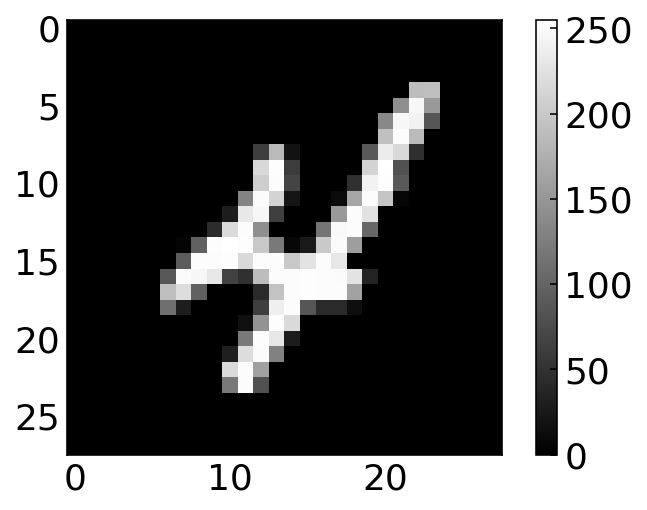

label:  4


In [241]:
i = 9
plt.imshow(X[i].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()
print('label: ',y[i])

### Normalize the data

To use data in neural networks as training data, it is always useful to normalize the data to the interval [0, 1].

In [242]:
X = X/255

### Preparing training and testing data

The default MNIST labels say '1' for an image of a one, '2' for an image of a two, etc., but we are just building a zero classifier for now. So we want our labels to say 1 when we have a zero, and 0 otherwise. So we overwrite the labels accordingly:

In [243]:
y_new = np.zeros(y.shape)
y_new[np.where(y == '0')[0]] = 1
y = y_new

We now split the data in a train and test set. The MNIST images are pre-arranged so that the first 60,000 can be used for training, and the last 10,000 for testing. We’ll also transform the data into the shape we want, with each example in a column (instead of a row):

In [244]:
m = 60000
m_test = X.shape[0] - m

X_train, X_test = X[:m].T, X[m:].T
y_train, y_test = y[:m].reshape(1,m), y[m:].reshape(1, m_test)

Finally, we shuffle the training set:

In [245]:
np.random.seed(1)
shuffle_index = np.random.permutation(m)
X_train, y_train = X_train[:,shuffle_index], y_train[:,shuffle_index]

Let’s again have a look at random image and label just to check

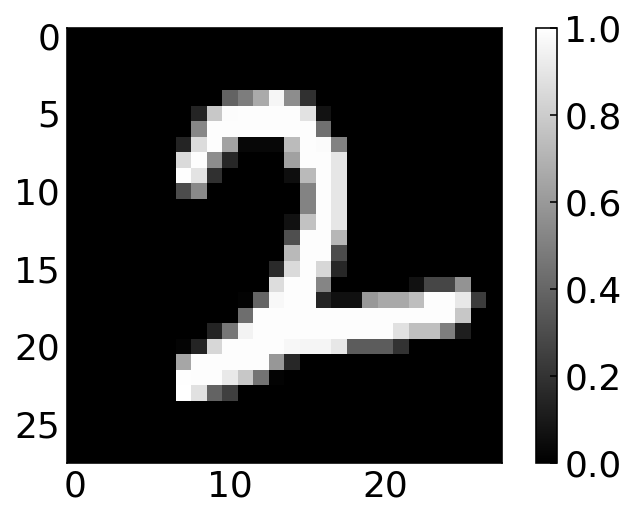

[0.]


In [270]:
i = 28
plt.imshow(X_train[:,i].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()
print(y_train[:,i])

Try to find a zero to check whether the corresponding label is a 1.

## A Single Neuron

The basic unit of a neural network is a neuron. A neuron takes inputs, does some math with them, and produces one output. The neuron below does that with two inputs. 

![image](img/neuron.png)


### Forward Propogation



The neuron does now three things.

1. Take input values and multipy by weights

\begin{eqnarray}
x_{1}\rightarrow x_{1} w_{1}\\
x_{2}\rightarrow x_{2} w_{2}
\end{eqnarray}

2. All the weighted inputs are the added to a bias value $b$

\begin{equation}
x_{1} w_{1}+ x_{2} w_{2}+b
\end{equation}

3. The output is generated by applying a function $\sigma()$
\begin{equation}
y=\sigma( x_{1} w_{1}+ x_{2} w_{2}+b)
\end{equation}

This function is called activation function. The activation function is used to turn an unbounded input value into a bounded output value with a predictable range. A commonly used activation function is the `sigmoid function`.


For a single input dataset $x$ a more compact writing of the math above is

\begin{equation*}
\hat{y} = \sigma(w^{\rm T} x + b)\ .
\end{equation*}

Here $\sigma$ is the sigmoid function:
\begin{equation*}
\sigma(z) = \frac{1}{1+{\rm e}^{-z}}\ .
\end{equation*}

The sigmoid function is something we can already define and plot.


In [272]:
u"\u2212"

'−'

In [66]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

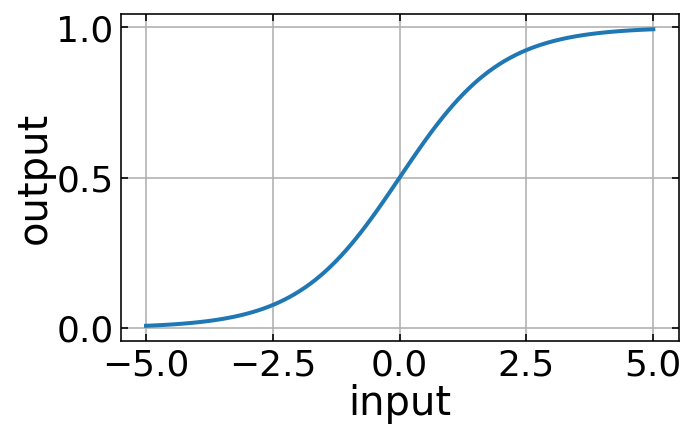

In [67]:
x=np.linspace(-5,5,100)
plt.figure(figsize=(5,3))
plt.plot(x,sigmoid(x))
plt.xlabel('input')
plt.ylabel('output')
plt.grid()
plt.show()

If we now have this kind of two input neuron with the weights $w$ and the bias value $b$

\begin{eqnarray}
w=[0,1]\\
b=4
\end{eqnarray}

we may supply and input 

\begin{eqnarray}
x=[2,3]
\end{eqnarray}

which gives writing it a s a dot product

\begin{equation}
y=f(w\cdot x+b)=f(7)=0.999
\end{equation}

This procedure of propagating the input values to obtain and output value is called **feedforward** or **forward propagation**. Our first goal is now to create a network with a single neuron with 784 inputs (28 x 28), and a single sigmoid unit generating the output.

The above examples can be written and executed more efficiently in a vectorized form. Generating the output We’ll vectorize by stacking examples side-by-side, so that our input matrix $X$ has an example in each column. The vectorized form of the forward pass is then

\begin{equation*}
\hat{y} = \sigma(w^{\rm T} X + b)\ .
\end{equation*}

Note that $\hat{y}$ is now a vector, not a scalar as it was in the previous equation. 

In our code we will compute this in two stages: `Z = np.matmul(W.T, X) + b` and then `A = sigmoid(Z)` (`A` for Activation). Breaking things up into stages like this is just for clarity - It will make our forward pass computations mirror the steps in our backward propagation computation.

### Loss Function

Since we have now data and we also know how to propagate (at least in principle) the input through the single neuron here, we also need to define a measure for how far the output deviates from the input. This measure is called **loss**. The many different ways of defining a suitable loss. The `mean squared error`, as it appeared already during our fitting lecture, could be a suitable loss function

\begin{equation}
MSE(y,\hat{y})=\frac{1}{n}\sum_{i=1}^{n}(y-\hat{y})^2
\end{equation}

for a number of $n$ datasets. Here $\hat{y}$ is the data that is predicted by the network and $y$ is the value which represents the so called ground truth, i.e. the data provided by the training set.


We will not use the mean squared error bu the  `cross-entropy` for our loss function. The formula for a single training example (one input image) is:

\begin{equation*}
L(y,\hat{y}) = -y\log(\hat{y})-(1-y)\log(1-\hat{y})\ .
\end{equation*}

This error definition comes from the Shannon entropy definition, which you may look up in the web if you are interested. Averaging over a training set of $m$ examples we then have:

\begin{equation*}
L(Y,\hat{Y}) = -\frac{1}{m}\sum_{i = 0}^{m}y^{(i)}\log(\hat{y}^{(i)})-(1-y^{(i)})\log(1-\hat{y}^{(i)})\ .
\end{equation*}

In Python code, this looks like 

In [68]:
def compute_loss(Y, Y_hat):
    m = Y.shape[1]
    L = -(1./m)*(np.sum(np.multiply(np.log(Y_hat), Y)) + np.sum(np.multiply(np.log(1 - Y_hat), (1 - Y))))
    return L

## Trainging the Network

The goal of all neural network training procedures is to minimize the loss and we have to find a way to minimize that loss. This is not so much different from our fitting of function values before.

### Backward Propagation

The output of the network is determined by the input values and how we have distributed the weights $w$ and the biases $b$. We can write the loss function therefore as a function of the weights and losses

$$
L(w_{1},w_{2},w_{3},\ldots ,b_{1},b_{2},b_{3},\ldots)
$$



To train the network, we would now try to find out, by how much the output values change if we do change a specific weight $w_j$. This can be expressed by the partial derivative 

$$
\frac{\partial L}{\partial w_j}
$$

We may then take a tiny step and correct the current value of $w_j$ such that the network yields a new output. This way back from the current output of the network and its current loss to a correction of the weights to yield a smaller loss is called **back propagation**.

**Calculating derivatives**

Focusing on a single input image will make it easier to derive the formulas we need. Holding all values except $w_j$ fixed, we can think of $L$ as being computed in three steps: $w_j\rightarrow z \rightarrow \hat{y} \rightarrow L$. The formulas for these steps are:
\begin{align*}
z &= w^{\rm T} x + b\ , \\
\hat{y} &= \sigma(z)\ , \\
L(y,\hat{y}) &= -y\log(\hat{y})-(1-y)\log(1-\hat{y})\ .
\end{align*}

The change of the loss function with the weights can then be split up by the chain rule into 

\begin{align*}
\frac{\partial L}{\partial w_j} = \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial z}\frac{\partial z}{\partial w_j}
\end{align*} <br>



There we have a product of three individual partial derivatives, which are a bit tedius to write down, but not to complicated. The read like

$\partial L/\partial\hat{y}$:
\begin{align*}
\frac{\partial L}{\partial\hat{y}} &= \frac{\partial}{\partial\hat{y}}\left(-y\log(\hat{y})-(1-y)\log(1-\hat{y})\right) \\
&= -y\frac{\partial}{\partial\hat{y}}\log(\hat{y})-(1-y)\frac{\partial}{\partial\hat{y}}\log(1-\hat{y}) \\
&= -\frac{y}{\hat{y}} +\frac{(1 - y)}{1-\hat{y}} \\
&= \frac{\hat{y} - y}{\hat{y}(1-\hat{y})}
\end{align*}


$\partial \hat{y}/\partial z$:
\begin{align*}
\frac{\partial }{\partial z}\sigma(z) 
&= \frac{\partial }{\partial z}\left(\frac{1}{1 + {\rm e}^{-z}}\right) \\
&= \frac{1}{(1 + {\rm e}^{-z})^2}\frac{\partial }{\partial z}(1 + {\rm e}^{-z}) \\
&= \frac{{\rm e}^{-z}}{(1 + {\rm e}^{-z})^2} \\
&= \frac{1}{1 + {\rm e}^{-z}}\frac{{\rm e}^{-z}}{1 + {\rm e}^{-z}} \\
&= \frac{1}{1 + {\rm e}^{-z}}\left(1 - \frac{1}{1 + {\rm e}^{-z}}\right) \\
&= \sigma(z)(1-\sigma(z)) \\
&= \hat{y}(1-\hat{y})
\end{align*}


$\partial z/\partial w_j$:
\begin{align*}
\frac{\partial }{\partial w_j}(w^{\rm T} x + b) &= \frac{\partial }{\partial w_j}(w_0x_0 + \dots + w_nx_n + b) \\
&= x_j
\end{align*}



Substituting back into the chain rule yields:
\begin{align*}
\frac{\partial L}{\partial w_j} 
&= \frac{\partial L}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial z}\frac{\partial z}{\partial w_j} \\
&= \frac{\hat{y} - y}{\hat{y}(1-\hat{y})}\hat{y}(1-\hat{y}) x_j \\
&= (\hat{y} - y)x_j\ .
\end{align*}

which does not look that unfriendly anymore. 


In vectorized form with $m$ training examples this gives us
\begin{align*}
\frac{\partial L}{\partial w} = \frac{1}{m} X(\hat{y} - y)^{\rm T}\ .
\end{align*}

A very similar derivation of $\partial L/\partial b$ yields, for a single example:
\begin{align*}
\frac{\partial L}{\partial b} = (\hat{y} - y)\ .
\end{align*}

In vectorized form we get
\begin{align*}
\frac{\partial L}{\partial b} = \frac{1}{m}\sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})}\ .
\end{align*}

In our code we label these gradients according to their denominators, as `dW` and `db`. So for backpropagation we compute `dW = (1/m) * np.matmul(X, (A-Y).T)` and `db = (1/m)*np.sum(A-Y, axis=1, keepdims=True)`.

### Stochastic Gradient Descent

We have all the tools we need to train a neural network now! We’ll use an optimization algorithm called stochastic gradient descent (SGD) that tells us how to change our weights and biases to minimize loss. It is a simple umpdate of the weights and biases, which would read for the weights like

$$
w\leftarrow w-\eta\frac{\partial L}{\partial w}
$$

where $\eta$ is a constant called the learning rate that controls how fast we train. All we’re doing is subtracting $\eta \partial L/\partial w$ from $w$

- If $\partial L/\partial w$  is positive, $w$ will decrease, which makes L decrease.
- If $\partial L/\partial w$  is negative, $w$ will increase, which makes L decrease.

The equations look equivalent for the bias $b$. Our back propagation procedure will do that for as many steps we want, i.e. until we feel that the output is close enough to the ground truth. Each back propagation step is called and `epoch`.

### Build an Train

Now we have all things together to create a single neuron network doing the analysis of the MNIST numbers. This type of data processing is called logistic regression based on the sigmoid function, which is a logistic function. So let's create all in python code and train the network for 100 epochs.

In [69]:
learning_rate = 1

X = X_train
Y = y_train

n_x = X.shape[0]
m = X.shape[1]

W = np.random.randn(n_x, 1) * 0.01
b = np.zeros((1, 1))

for i in range(100):
    Z = np.matmul(W.T, X) + b
    A = sigmoid(Z)

    loss = compute_loss(Y, A)

    dW = (1/m)*np.matmul(X, (A-Y).T)
    db = (1/m)*np.sum(A-Y, axis=1, keepdims=True)

    W = W - learning_rate * dW
    b = b - learning_rate * db
    
    if i % 10 == 0:
        print("Epoch", i, " loss: ", loss)

print("Final loss:", loss)

Epoch 0  loss:  0.7471125121616977
Epoch 10  loss:  0.0730826958292902
Epoch 20  loss:  0.06131832354627721
Epoch 30  loss:  0.055230119812005714
Epoch 40  loss:  0.0513243202361425
Epoch 50  loss:  0.04854004196371184
Epoch 60  loss:  0.04642485272904433
Epoch 70  loss:  0.04474722082574824
Epoch 80  loss:  0.043374333931969114
Epoch 90  loss:  0.042223715518407964
Final loss: 0.04133292114839401


We do not really now how to judge the quality of our trained network. At least we saw that the loss is decreasing, which is good. We may judge the quality of our trained network by calculating the so-called **confusion matrix**. The confusion matrix is creating a matrix giving reports the actual values in the rows and the predicted values in the columns. 

![confusion_matrix](confusion_matrix.png)

The entries in the matrix are called **true positives** (TP), **false positives** (FP), **false negatives** (FN), and **true negatives** (TN). Fortunately we can use a method of the `sklearn` module to calculate the confusion matrix. We just have to supply the predictions and the actual labels to it. To do so, we use the testing data set `X_test` which we have splitted earlier.

In [73]:
from sklearn.metrics import confusion_matrix, classification_report

Z = np.matmul(W.T, X_test) + b
A = sigmoid(Z)

predictions = (A>.5)[0,:]
labels = (y_test == 1)[0,:]

print(confusion_matrix(predictions, labels))

[[8973   42]
 [  47  938]]


In [92]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      9015
        True       0.96      0.95      0.95       985

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.99      0.99      0.99     10000



### Testing our model

We can check a single image of our testing data with the following line. If the output number is bigger than 0.5, our number is likely a 0.

In [232]:
i=10
bool(sigmoid(np.matmul(W.T, X_test[:,i])+b)>0.5)

True

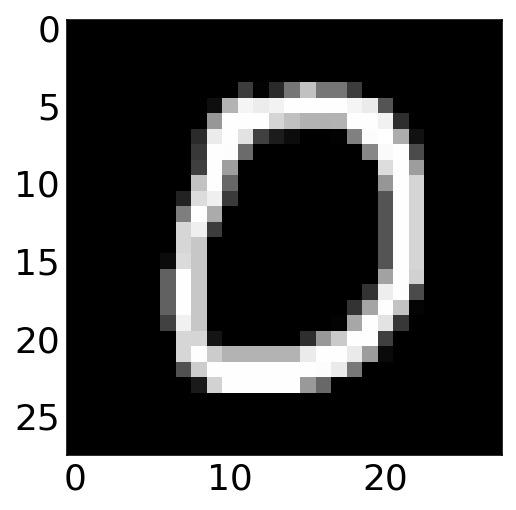

In [231]:
plt.imshow(X_test[:,i].reshape(28,28),cmap='gray')

That’s actually pretty good! We predicted the right values for 8972 cases. We missed only 41 of the cases. 

## Network with Hidden Layers

In our example above, we just had an input layer and a single output neuron. More complex neural networks are containing many layers between the input layer and the output layer. These inbetween layers are called hidden layers. Here is a simple example of a neural network with a single hidden layer.

![hidden](image.png)

So we have now and input layer with 784 inputs that are connected to 64 units in the hidden layer and 1 neuron in the output layer. We will not go through the derivations of all the formulas for the forward and backward passes this time. The code is a simple extension of what we did before and I hope easy to read.

In [117]:
X = X_train
Y = y_train

n_x = X.shape[0]
n_h = 64
learning_rate = 1

W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(1, n_h)
b2 = np.zeros((1, 1))

for i in range(100):

    Z1 = np.matmul(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = sigmoid(Z2)

    loss = compute_loss(Y, A2)

    dZ2 = A2-Y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    if i % 10 == 0:
        print("Epoch", i, "loss: ", loss)

print("Final loss:", loss)

Epoch 0 loss:  2.395166635058746
Epoch 10 loss:  0.2207416875926896
Epoch 20 loss:  0.16601548222727533
Epoch 30 loss:  0.13990677867922954
Epoch 40 loss:  0.12390102523919129
Epoch 50 loss:  0.11269161497108851
Epoch 60 loss:  0.10421329497723456
Epoch 70 loss:  0.09747959072905935
Epoch 80 loss:  0.09194898313097832
Epoch 90 loss:  0.0872943606401609
Final loss: 0.08367740628296327


To judge the newtork quality we do use again the confusion matrix. 

In [118]:
Z1 = np.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = sigmoid(Z2)

predictions = (A2>.5)[0,:]
labels = (y_test == 1)[0,:]

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[8905  178]
 [ 115  802]]
              precision    recall  f1-score   support

       False       0.99      0.98      0.98      9083
        True       0.82      0.87      0.85       917

    accuracy                           0.97     10000
   macro avg       0.90      0.93      0.91     10000
weighted avg       0.97      0.97      0.97     10000



## Multiclass Network

So far we did only classify if the number we feed to the network is just a 0 or not. We would like to recognize the different number now and therefore need a multiclass network. Each number is then a class and per class, we have multiple realizations of handwritten numbers. We therefore have to create an output layer, which is not only containing a single neuron, but 10 neurons. Each of these neuron can output a value between 0 and 1. Whenever the output is 1, the index of the neuron represents the number predicted. 

The output array

~~~
[0,1,0,0,0,0,0,0,0,0]
~~~

would therefore correspond to the value 1.

For this purpose, we need to reload the right labels.

In [120]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X / 255

Then we’ll one-hot encode MNIST’s labels, to get a 10 x 70,000 array.

In [121]:
digits = 10
examples = y.shape[0]

y = y.reshape(1, examples)

Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

We also seperate into trainging and testing data

In [122]:
m = 60000
m_test = X.shape[0] - m

X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]

shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

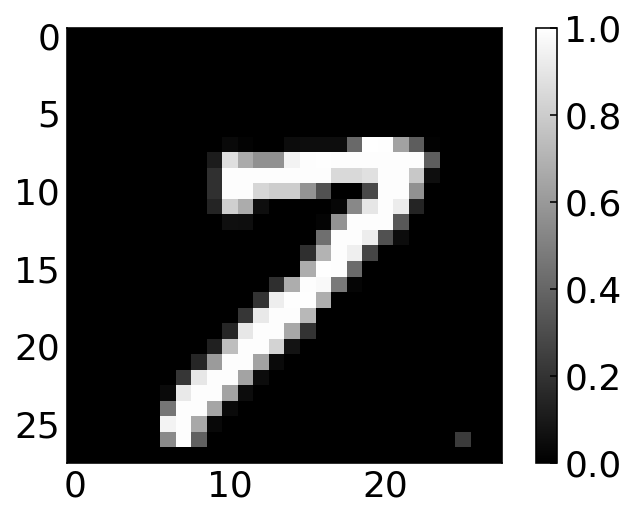

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [123]:
i = 56
plt.imshow(X_train[:,i].reshape(28,28), cmap='gray')
plt.colorbar()
plt.show()
Y_train[:,i]

### Changes to the model

OK, so let’s consider what changes we need to make to the model itself.

#### Forward Pass
Only the last layer of our network is changing. To add the softmax, we have to replace our lone, final node with a 10 unit layer. Its final activations are the exponentials of its z-values, normalized across all ten such exponentials. So instead of just computing $\sigma(z)$, we compute the activation for each unit $i$ using the softmax function:
\begin{align*}
\sigma(z)_i = \frac{{\rm e}^{z_i}}{\sum_{j=0}^9{\rm e}^{z_i}}\ .
\end{align*}

So, in our vectorized code, the last line of forward propagation will be `A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)`.

#### Loss Function

Our loss  function now has to generalize to more than two classes. The general formula for $n$ classes is:
\begin{align*}
L(y,\hat{y}) = -\sum_{i=0}^n y_i\log(\hat{y}_i)\ .
\end{align*}
Averaging over $m$ training examples this becomes:
\begin{align*}
L(y,\hat{y}) = -\frac{1}{m}\sum_{j=0}^m\sum_{i=0}^n y_i^{(i)}\log(\hat{y}_i^{(i)})\ .
\end{align*}


So let's define:

In [124]:
def compute_multiclass_loss(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum
    return L

#### Back Propagation

Luckily it turns out that back propagation isn’t really affected by the switch to a softmax. A softmax generalizes the sigmoid activiation we’ve been using, and in such a way that the code we wrote earlier still works. We could verify this by deriving:
\begin{align*}
\frac{\partial L}{\partial z_i} = \hat{y}_i - y_i\ .
\end{align*}

But we won’t walk through the steps here. Let’s just go ahead and build our final network.

### Build and Train

As we have now more weights and classes, the training takes longer and we actually need also more episodes to achieve a good accuracy.

In [164]:
n_x = X_train.shape[0]
n_h = 64
learning_rate = 1

W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(digits, n_h)
b2 = np.zeros((digits, 1))

X = X_train
Y = Y_train

for i in range(200):

    Z1 = np.matmul(W1,X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2,A1) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

    loss = compute_multiclass_loss(Y, A2)

    dZ2 = A2-Y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    if (i % 10 == 0):
        print("Epoch", i, "loss: ", loss)

print("Final loss:", loss)

Epoch 0 loss:  6.754143565789832
Epoch 10 loss:  2.31326090354495
Epoch 20 loss:  1.6043877614303914
Epoch 30 loss:  1.2890004717094106
Epoch 40 loss:  1.1093197423471932
Epoch 50 loss:  0.9921173974283636
Epoch 60 loss:  0.908578404826914
Epoch 70 loss:  0.8453729163436552
Epoch 80 loss:  0.7955216748114543
Epoch 90 loss:  0.7549647468170931
Epoch 100 loss:  0.7211663466471266
Epoch 110 loss:  0.6924500602072033
Epoch 120 loss:  0.6676609441459171
Epoch 130 loss:  0.6459794129595765
Epoch 140 loss:  0.6268055274703503
Epoch 150 loss:  0.6096880566510727
Epoch 160 loss:  0.5942807158842909
Epoch 170 loss:  0.5803132060530969
Epoch 180 loss:  0.5675711192192956
Epoch 190 loss:  0.5558818101632366
Final loss: 0.5461445785100992


Let’s see how we did:

In [234]:
Z1 = np.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

predictions = np.argmax(A2, axis=0)
labels = np.argmax(Y_test, axis=0)

#### Model performance

In [236]:
print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[ 907    0   14    2    4   25   29   10   14   10]
 [   0 1102   16    6    2    7    5   17    4    7]
 [   9    6  850   33   13   19   27   30   37   17]
 [   6    6   24  816    7   62    4    5   54   22]
 [   2    0   15    7  824   22   30   19   21   75]
 [  32    2    8   62    8  666   22    4   51   11]
 [  18    4   28    7   21   28  829    3   23    5]
 [   3    0   24   16    3    9    1  857   16   39]
 [   3   14   42   51   21   48    8   12  736   14]
 [   0    1   11   10   79    6    3   71   18  809]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1015
           1       0.97      0.95      0.96      1166
           2       0.82      0.82      0.82      1041
           3       0.81      0.81      0.81      1006
           4       0.84      0.81      0.83      1015
           5       0.75      0.77      0.76       866
           6       0.87      0.86      0.86       966
           7       0.83      0.89   

We are at 84% accuray across all digits, which could be of course better. We may now plot image and the corresponding prediction.

## Test the model

6

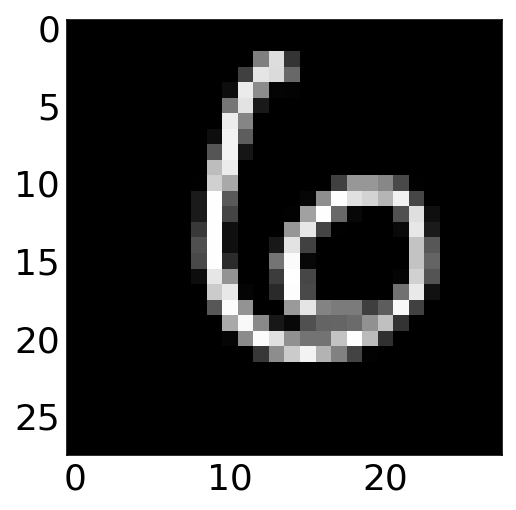

In [237]:
i=100
plt.imshow(X_test[:,i].reshape(28,28), cmap='gray')
predictions[i]